##  2.2 MLP Regressor for Price Prediction in Bangalore

### 2.2.2 Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os

In [2]:
house_dataset = pd.read_csv('Bengaluru_House_Data.csv')
missing_values = house_dataset.isnull().sum()
print(missing_values[missing_values > 0])
print(house_dataset.shape)
print(house_dataset.columns)

location       1
size          16
society     5502
bath          73
balcony      609
dtype: int64
(13320, 9)
Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [6]:
print(house_dataset.columns)


Index(['area_type', 'availability', 'location', 'total_sqft', 'bath',
       'balcony', 'price', 'BHK'],
      dtype='object')


In [7]:
house_dataset['location'] = house_dataset['location'].fillna(house_dataset['location'].mode()[0])

if 'size' in house_dataset.columns:
    house_dataset['BHK'] = house_dataset['size'].str.extract('(\d+)').astype(float)
    house_dataset['BHK'] = house_dataset['BHK'].fillna(house_dataset['BHK'].median())
    house_dataset = house_dataset.drop('size', axis=1)  

if 'society' in house_dataset.columns:
    house_dataset = house_dataset.drop('society', axis=1)

house_dataset['balcony'] = house_dataset['balcony'].fillna(house_dataset['balcony'].mode()[0])
house_dataset['bath'] = house_dataset['bath'].fillna(house_dataset['bath'].median())


In [8]:
missing_values = house_dataset.isnull().sum()
print(missing_values[missing_values > 0])
print(house_dataset.shape)

Series([], dtype: int64)
(13320, 8)


In [9]:
import re
# total_sqft has ranges -> single number

def convert_sqft(x):
    x = re.sub('[^0-9.-]','',x)

    if x.endswith('.'):
        x=x[:-1]

    if '-' in x:
        low, high = map(float,x.split('-'))
        return (low+high)/2
    else:
        return float(x)
    
house_dataset['total_sqft'] = house_dataset['total_sqft'].apply(convert_sqft)

In [10]:
#for summary statistics
house_dataset.describe()

,total_sqft,bath,balcony,price,BHK
count,13320.000000,13320.000000,13320.000000,13320.000000,13320.000000
mean,1555.971707,2.688814,1.603378,112.565627,2.803979
std,1238.902448,1.338754,0.803067,148.971674,1.294214
min,1.000000,1.000000,0.000000,8.000000,1.000000
25%,1100.000000,2.000000,1.000000,50.000000,2.000000
50%,1275.000000,2.000000,2.000000,72.000000,3.000000
75%,1679.250000,3.000000,2.000000,120.000000,3.000000
max,52272.000000,40.000000,3.000000,3600.000000,43.000000


In [11]:
house_dataset.columns

Index(['area_type', 'availability', 'location', 'total_sqft', 'bath',
       'balcony', 'price', 'BHK'],
      dtype='object')

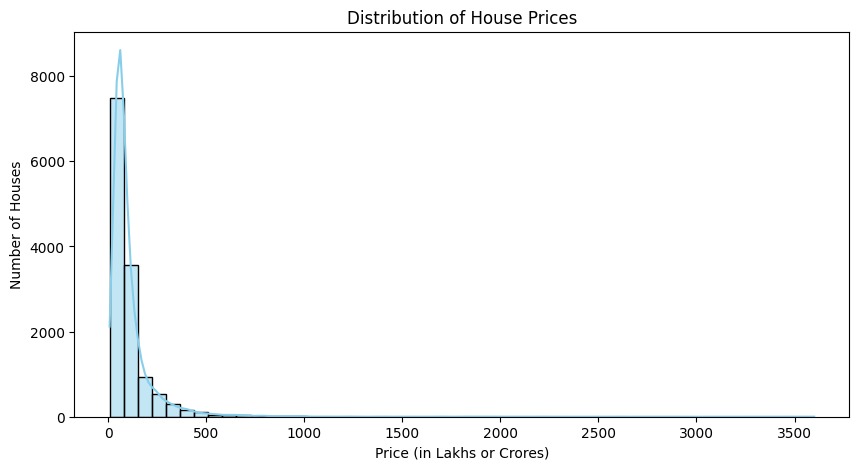

In [12]:
#  label distribution across the dataset

import seaborn as sns 
plt.figure(figsize=(10, 5))
sns.histplot(house_dataset['price'], bins=50, color='skyblue', kde=True)

plt.title('Distribution of House Prices')
plt.xlabel('Price (in Lakhs or Crores)')
plt.ylabel('Number of Houses')
plt.show()

Categorical Encoding:
- area_type: It has few categories hence label encoding will be efficient   (Super Built-up Area -> 0  
Plot Area           -> 1  
Built-up Area       -> 2  )
- availability: The entries are either 'Ready To Move' or particular unique date hence binary mapping will be useful(Ready to Move -> 1 and other future dates -> 0)
- location: Since many unique entries are there ,frequency encoding i.e, converting locations to how many times they appear would be best.

In [13]:
# Categorical encoding
from sklearn.preprocessing import LabelEncoder

#area_type
label_encoder = LabelEncoder()
house_dataset['area_type'] = label_encoder.fit_transform(house_dataset['area_type'])

#availability
if 'availability' in house_dataset.columns:
    house_dataset['availability_ready'] = house_dataset['availability'].apply(
        lambda x: 1 if x == 'Ready To Move' else 0
    )
    house_dataset.drop(columns=['availability'], inplace=True)

#location
location_count = house_dataset['location'].value_counts().to_dict()
house_dataset['location_frequency'] = house_dataset['location'].map(location_count)

house_dataset.drop(columns=[ 'location'], inplace=True)





In [14]:
print(house_dataset.head)

<bound method NDFrame.head of        area_type  total_sqft  bath  balcony   price  BHK  availability_ready  \
0              3      1056.0   2.0      1.0   39.07  2.0                   0   
1              2      2600.0   5.0      3.0  120.00  4.0                   1   
2              0      1440.0   2.0      3.0   62.00  3.0                   1   
3              3      1521.0   3.0      1.0   95.00  3.0                   1   
4              3      1200.0   2.0      1.0   51.00  2.0                   1   
...          ...         ...   ...      ...     ...  ...                 ...   
13315          0      3453.0   4.0      0.0  231.00  5.0                   1   
13316          3      3600.0   5.0      2.0  400.00  4.0                   1   
13317          0      1141.0   2.0      1.0   60.00  2.0                   1   
13318          3      4689.0   4.0      1.0  488.00  4.0                   0   
13319          3       550.0   1.0      1.0   17.00  1.0                   1   

       lo

In [15]:
#train-test-split
from sklearn.model_selection import train_test_split

X = house_dataset.drop(columns=['price'])
y = house_dataset['price']

# 70-15-15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train Set Shape:", X_train.shape)
print("Validation Set Shape:", X_val.shape)
print("Test Set Shape:", X_test.shape)



Train Set Shape: (9324, 7)
Validation Set Shape: (1998, 7)
Test Set Shape: (1998, 7)


In [18]:
#scaling & standardizing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Train Shape:", X_train_scaled.shape)
print("Validation Shape:", X_val_scaled.shape)
print("Test Shape:", X_test_scaled.shape)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


Train Shape: (9324, 7)
Validation Shape: (1998, 7)
Test Shape: (1998, 7)


##  2.2.3 Model Development from Scratch

In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Activation Functions 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

# MLP Class
class MLP:
    def __init__(self, input_size, hidden_layers, output_size, activation='relu', learning_rate=0.01, optimizer='sgd', batch_size=None):
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.batch_size = batch_size

        self.loss_history = []
  
        self.activation, self.activation_derivative = {
            'sigmoid': (sigmoid, sigmoid_derivative),
            'tanh': (tanh, tanh_derivative),
            'relu': (relu, relu_derivative)
        }[activation]
     
        self.layers = [input_size] + hidden_layers + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2 / self.layers[i]) for i in range(len(self.layers) - 1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers) - 1)]

    def forward(self, X):
        self.a = [X] 
        self.z = []  
        
        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.z.append(z)
            if i == len(self.weights) - 1:
                a = z 
            else:
                a = self.activation(z)
            self.a.append(a)
        
        return self.a[-1]

    def backward(self, X, y):
        m = X.shape[0]
        output_error = self.a[-1] - y  
        errors = [output_error]

        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(errors[-1], self.weights[i].T) * self.activation_derivative(self.a[i])
            delta = np.clip(delta, -1, 1)
            errors.append(delta)

        errors.reverse()

        for i in range(len(self.weights)):
            grad_w = np.dot(self.a[i].T, errors[i]) / m
            grad_b = np.mean(errors[i], axis=0, keepdims=True)

            grad_w = np.clip(grad_w, -1, 1)
            grad_b = np.clip(grad_b, -1, 1)

            self.weights[i] -= self.learning_rate * grad_w
            self.biases[i] -= self.learning_rate * grad_b

    def train(self, X, y, epochs=100):
        for epoch in range(epochs):
            if self.optimizer == 'sgd':
                self.sgd(X, y)
            elif self.optimizer == 'batch':
                self.batch_gradient_descent(X, y)
            elif self.optimizer == 'mini-batch':
                self.mini_batch_gradient_descent(X, y)

            # Track loss
            loss = np.mean((self.forward(X) - y) ** 2)
            self.loss_history.append(loss)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {loss:.5f}")

    def sgd(self, X, y):
        for i in range(X.shape[0]):
            self.forward(X[i:i+1])
            self.backward(X[i:i+1], y[i:i+1])

    def batch_gradient_descent(self, X, y):
        self.forward(X)
        self.backward(X, y)

    def mini_batch_gradient_descent(self, X, y):
        batch_size = self.batch_size if self.batch_size else X.shape[0] // 10
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            self.forward(X_batch)
            self.backward(X_batch, y_batch)

    def predict(self, X):
        return self.forward(X)

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.title('Training Loss')
        plt.show()

    def evaluate(self, X, y):
        y_pred = self.forward(X)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y, y_pred)
        print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2 Score: {r2:.4f}')
        return mse, rmse, r2

Epoch 0: Loss = 0.66533
Epoch 10: Loss = 0.58513
Epoch 20: Loss = 0.45504
Epoch 30: Loss = 0.58537
Epoch 40: Loss = 0.46042


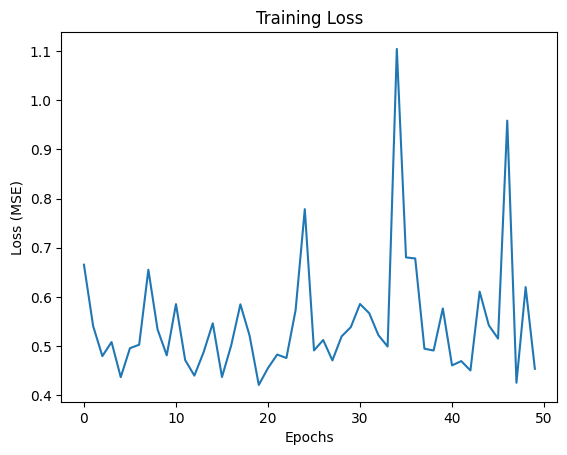

Validation Results: MSE: 13767.4778, RMSE: 117.3349, R2: 0.4779
Test Results: MSE: 12698.0697, RMSE: 112.6857, R2: 0.3519


In [21]:
import numpy as np
import matplotlib.pyplot as plt

mlp = MLP(input_size=X_train_scaled.shape[1], hidden_layers=[64, 32], output_size=1, 
          activation='relu', learning_rate=0.1, optimizer='sgd', batch_size=64)

mlp.train(X_train_scaled, y_train_scaled.reshape(-1, 1), epochs=50)
mlp.plot_loss()

# validation and test evaluation
y_pred_val_scaled = mlp.predict(X_val_scaled)
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled)
mse_val = mean_squared_error(y_val, y_pred_val)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_val, y_pred_val)

y_pred_test_scaled = mlp.predict(X_test_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

# Print Results
print(f"Validation Results: MSE: {mse_val:.4f}, RMSE: {rmse_val:.4f}, R2: {r2_val:.4f}")
print(f"Test Results: MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")


Training with sigmoid activation, sgd optimizer, LR=0.01, Epochs=50, Hidden Layers=[64, 32]
Epoch 0: Loss = 0.73474
Epoch 10: Loss = 0.66343
Epoch 20: Loss = 0.65230
Epoch 30: Loss = 0.64171
Epoch 40: Loss = 0.63030
Training with sigmoid activation, sgd optimizer, LR=0.01, Epochs=50, Hidden Layers=[128, 64]
Epoch 0: Loss = 0.71521
Epoch 10: Loss = 0.67396
Epoch 20: Loss = 0.66151
Epoch 30: Loss = 0.65136
Epoch 40: Loss = 0.64541
Training with sigmoid activation, sgd optimizer, LR=0.01, Epochs=100, Hidden Layers=[64, 32]
Epoch 0: Loss = 0.70108
Epoch 10: Loss = 0.64303
Epoch 20: Loss = 0.63119
Epoch 30: Loss = 0.61514
Epoch 40: Loss = 0.60685
Epoch 50: Loss = 0.59885
Epoch 60: Loss = 0.58959
Epoch 70: Loss = 0.57702
Epoch 80: Loss = 0.55787
Epoch 90: Loss = 0.51475
Training with sigmoid activation, sgd optimizer, LR=0.01, Epochs=100, Hidden Layers=[128, 64]
Epoch 0: Loss = 0.71534
Epoch 10: Loss = 0.64875
Epoch 20: Loss = 0.64206
Epoch 30: Loss = 0.63721
Epoch 40: Loss = 0.63396
Epoch 5

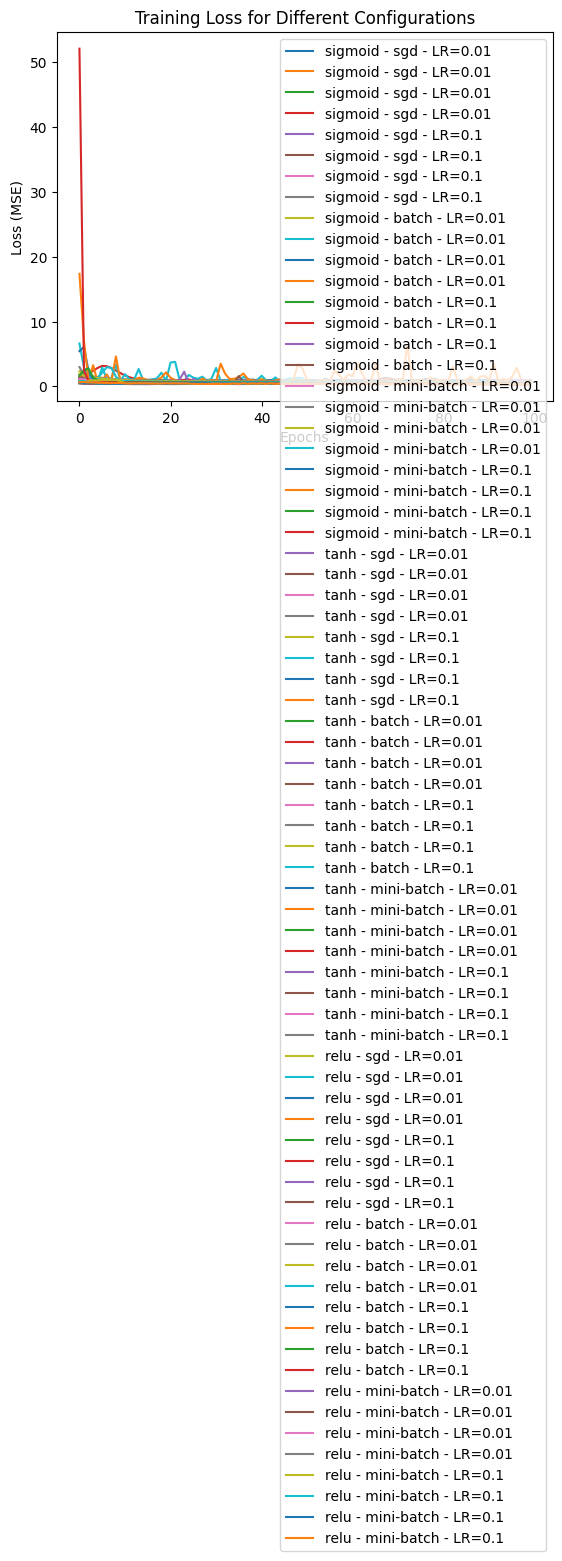


Best Configuration: {'Activation': 'tanh', 'Optimizer': 'sgd', 'Learning Rate': 0.1, 'Epochs': 50, 'Hidden Layers': [64, 32], 'R²': -5785.382152476392}

Evaluation Results (Ordered by Test MSE):
   Activation   Optimizer  Learning Rate  Epochs Hidden Layers     MSE (Val)  \
28       tanh         sgd           0.10      50      [64, 32]   5129.559574   
27       tanh         sgd           0.01     100     [128, 64]   6606.218450   
30       tanh         sgd           0.10     100      [64, 32]   9797.912271   
25       tanh         sgd           0.01      50     [128, 64]  10071.276548   
24       tanh         sgd           0.01      50      [64, 32]  11249.478206   
..        ...         ...            ...     ...           ...           ...   
70       relu  mini-batch           0.10     100      [64, 32]  33972.061312   
55       relu         sgd           0.10     100     [128, 64]  38967.243042   
68       relu  mini-batch           0.10      50      [64, 32]  39182.160296   
46  

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def tune_model(X_train_scaled, y_train_scaled, X_val_scaled, y_val, X_test_scaled, y_test):
    activation_functions = ['sigmoid', 'tanh', 'relu']
    optimizers = ['sgd', 'batch', 'mini-batch']
    learning_rates = [0.01, 0.1]
    epochs_list = [50, 100]
    hidden_layers = [[64, 32], [128, 64]]
    
    best_config = None
    best_score = float('inf')

    results = []
    
    for activation in activation_functions:
        for optimizer in optimizers:
            for lr in learning_rates:
                for epochs in epochs_list:
                    for hidden_layer in hidden_layers:
                        print(f"Training with {activation} activation, {optimizer} optimizer, LR={lr}, Epochs={epochs}, Hidden Layers={hidden_layer}")
               
                        mlp = MLP(input_size=X_train_scaled.shape[1], hidden_layers=hidden_layer, output_size=1, 
                                  activation=activation, learning_rate=lr, optimizer=optimizer, batch_size=64)
                        
                        mlp.train(X_train_scaled, y_train_scaled.reshape(-1, 1), epochs=epochs)
                        
                        # Plot loss curves for each configuration
                        plt.plot(mlp.loss_history, label=f'{activation} - {optimizer} - LR={lr}')
                        
                        # Evaluate on validation set
                        y_pred_val_scaled = mlp.predict(X_val_scaled)
                        y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled)
                        mse_val = mean_squared_error(y_val, y_pred_val)
                        rmse_val = np.sqrt(mse_val)
                        r2_val = r2_score(y_val, y_pred_val)

                        y_pred_test_scaled = mlp.predict(X_test_scaled)
                        y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
                        mse_test = mean_squared_error(y_test, y_pred_test)
                        rmse_test = np.sqrt(mse_test)
                        r2_test = r2_score(y_test, y_pred_test)

                        #evaluation metrics
                        results.append({
                            'Activation': activation,
                            'Optimizer': optimizer,
                            'Learning Rate': lr,
                            'Epochs': epochs,
                            'Hidden Layers': hidden_layer,
                            'MSE (Val)': mse_val,
                            'RMSE (Val)': rmse_val,
                            'R2 (Val)': r2_val,
                            'MSE (Test)': mse_test,
                            'RMSE (Test)': rmse_test,
                            'R2 (Test)': r2_test
                        })
                        
                        #best configuration
                        if mse_test < best_score:
                            best_score = mse_test
                            best_config = {
                                'Activation': activation,
                                'Optimizer': optimizer,
                                'Learning Rate': lr,
                                'Epochs': epochs,
                                'Hidden Layers': hidden_layer,
                                'R²': r2_test
                            }

    # training loss curves
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Loss for Different Configurations')
    plt.legend(loc='best')
    plt.show()
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='MSE (Test)')
    print("\nBest Configuration:", best_config)
    print("\nEvaluation Results (Ordered by Test MSE):")
    print(results_df)

    return results_df, best_config

results_df, best_config = tune_model(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled)
